In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2
import random
import shutil
import glob

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import keras.backend as k

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Train, Valid Split 안되어 있을 경우 아래 코드 먼저 실행

## Train, Valid Split

1) 폴더 생성하고 이미지 나누기
이미 TrainSet, ValidSet을 나눠두셨으면 아래 코드는 넘어가시면 됩니다.

In [2]:
#폴더 경로를 설정해줍니다.
os.chdir('./1. open') 

In [3]:
# train, val folder 생성

root_dir = os.getcwd()

train_path = root_dir + '/train'
if not os.path.isdir(train_path): 
    os.makedirs(train_path)
    
val_path = root_dir + '/valid'
if not os.path.isdir(val_path): 
    os.makedirs(val_path)
    
# validation용 파일은 10% 비율로 random sampling
# random.seed() 넣으시면 복원 가능
src = "train_imgs"
all_filename = os.listdir(src)
valid_filename = random.sample(all_filename, int(len(all_filename) * 0.1))
train_filename = [x for x in all_filename if x not in valid_filename]

print(len(train_filename), len(valid_filename))

train_filename = [src+'/'+ name for name in train_filename]
valid_filename = [src+'/' + name for name in valid_filename]

print('Total images: ', len(all_filename))
print('Training: ', len(train_filename))
print('Validation: ', len(valid_filename))

# copy & paste images
for name in tqdm(train_filename):
    shutil.copy(name, train_path)

for name in tqdm(valid_filename):
    shutil.copy(name, val_path)

  1%|▌                                                                           | 31/3776 [00:00<00:24, 150.69it/s]

3776 419
Total images:  4195
Training:  3776
Validation:  419


100%|████████████████████████████████████████████████████████████████████████████| 419/419 [00:01<00:00, 354.83it/s]


2) train, valid csv 파일 생성

In [4]:
all_train = pd.read_csv('train_df.csv')

all_train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,...,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,...,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [5]:
# train, valid folder 속 모든 이미지 파일 read & sort
train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./valid/*.jpg')
train_paths.sort()
valid_paths.sort()

train_filename = []
valid_filename = []

for t_paths in tqdm(train_paths):
    filename = t_paths.split('/')[-1]
    filename = filename.split('\\')[-1]
    train_filename.append(filename)

for v_paths in tqdm(valid_paths):
    filename = v_paths.split('/')[-1]
    filename = filename.split('\\')[-1]
    valid_filename.append(filename)

100%|█████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:00<?, ?it/s]


In [6]:
# 각각의 train, valid 이미지들의 정보만을 담고 있는 DataFrame 생성
train_df = all_train[all_train['image'].isin(train_filename)]
train_df.reset_index(inplace=True, drop=True)

valid_df = all_train[all_train['image'].isin(valid_filename)]
valid_df.reset_index(inplace=True, drop=True)

train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [7]:
#제공된 데이터들의 리스트를 확인합니다.
os.listdir()

['sample_submission.csv',
 'test_imgs',
 'test_imgs.zip',
 'train',
 'train.csv',
 'train_df.csv',
 'train_imgs',
 'train_imgs.zip',
 'valid',
 'valid.csv']

## 데이터 불러오고 살펴보기

In [3]:
# 해당 코드는 아래 Train, Valid Split 이후에 실행
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')

train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./valid/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')
print(len(train_paths), len(valid_paths), len(test_paths))

train_paths.sort()
valid_paths.sort()
test_paths.sort()

train['path'] = train_paths
valid['path'] = valid_paths

3776 419 1600


In [4]:
train.shape, valid.shape

((3776, 50), (419, 50))

## 데이터 시각화

(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)
(1920, 1080)


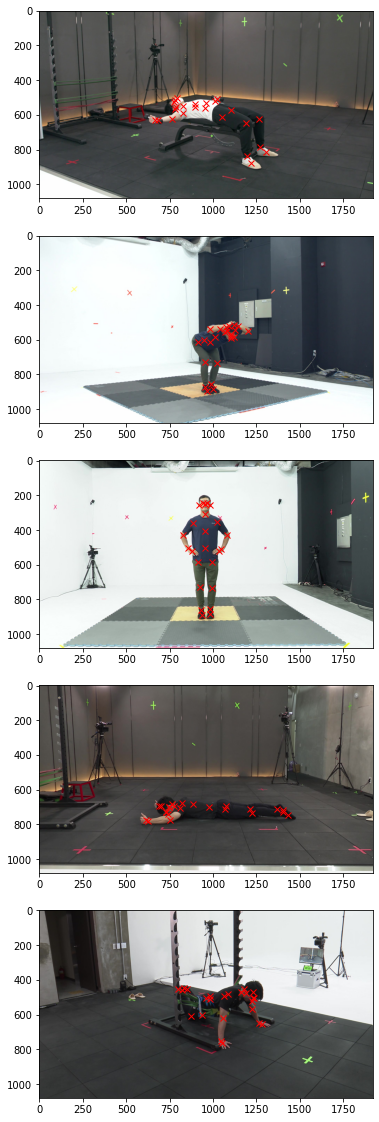

In [5]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    print(img.size)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

## Augmentation

In [13]:
def trainGenerator():
    # 원본 이미지 resize
    for i in range(len(train)):
        img = Image.open(train['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255                         # 이미지 rescaling
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

        yield (img, target)
        
def validGenerator():
    # 원본 이미지 resize
    for i in range(len(valid)):
        img = Image.open(valid['path'][i])  # path(경로)를 통해 이미지 읽기
        img = img.resize([480, 270])  # 이미지 resize
        img = np.array(img)  # 넘파이 배열로 변환
        img = img/255                         # 이미지 rescaling
        target = valid.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        target = target/4                     # image size를 1920x1080 -> 480x270으로 바꿔줬으므로 keypoint도 변경

        yield (img, target)

In [32]:
batch_size = 32

train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(batch_size).prefetch(1)
valid_dataset = tf.data.Dataset.from_generator(validGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
valid_dataset = valid_dataset.batch(batch_size).prefetch(1)

## 모델링

In [33]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(270,480,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

In [34]:
checkpointer = ModelCheckpoint(filepath = './model/{epoch:02d}-{val_mae:.4f}.hdf5', monitor='val_mae',
                               verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='mae', patience=3)

In [35]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [36]:
model.fit(train_dataset, epochs=10, steps_per_epoch=3, validation_data=valid_dataset, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[4,32,270,480] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_3/batch_normalization_13/FusedBatchNormGradV3-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_5937]

Function call stack:
train_function


In [3]:
save_model = load_model('./model/07-26.0558.hdf5')

In [4]:
test_paths = glob.glob('./test_imgs/*.jpg')
test_paths.sort()
X_test=[]

for test_path in tqdm(test_paths):
    img = Image.open(test_path)  # path(경로)를 통해 이미지 읽기
    img = img.resize([480, 270])  # 이미지 resize
    img = np.array(img)  # 넘파이 배열로 변환
    img = img/255  
    X_test.append(img)

X_test=tf.stack(X_test, axis=0)
X_test.shape

100%|███████████████████████████████████████████████████████████████████████████| 1600/1600 [01:38<00:00, 16.18it/s]


TensorShape([1600, 270, 480, 3])

In [6]:
# pred = save_model.predict(X_test, steps=1)
pred = []
i, chunksize = 0, 10
for idx in range(0, len(X_test), chunksize):
    pred += list(save_model.predict(X_test[idx:(i+1)*chunksize],
                verbose=1, batch_size=1))
    i += 1
pred = np.array(pred)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run StridedSlice: Dst tensor is not initialized. [Op:StridedSlice] name: strided_slice/

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission.iloc[:,1:] = pred * 4     # image size를 1920x1080 -> 480x270으로 바꿔서 예측했으므로 * 4
# submission

In [9]:
submission.to_csv('baseline.csv', index=False)

In [23]:
submission = pd.read_csv('./baseline.csv')

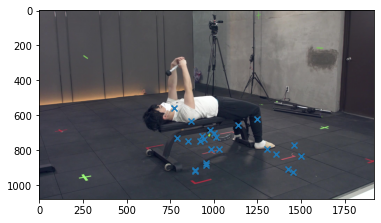

In [27]:
# 예측 결과 시각화
n = random.randint(0, 1600)
predicted_keypoint = submission.iloc[n,1:49]
predicted_keypoint = np.array(predicted_keypoint)
img = Image.open(test_paths[n])
#plt.save('./test.png')
plt.imshow(img)
plt.scatter(predicted_keypoint[0::2], predicted_keypoint[1::2], marker='x')